# Midjourney bot

copyright 2023, Denis Rothman

[Reference article by Michael King on Medium](https://medium.com/@neonforge/how-to-create-a-discord-bot-to-download-midjourney-images-automatically-python-step-by-step-guide-3e76d3282871)

In [ ]:
!pip install discord.py python-dotenv Pillow requests

In [ ]:
#Midjourney token
#Store you key in a file and read it(you can type it directly in the notebook but it will be visible for somebody next to you)
from google.colab import drive
drive.mount('/content/drive')
f = open("drive/MyDrive/files/midjourney.txt", "r")
MID_TOKEN=f.readline()
f.close()

Mounted at /content/drive


In [ ]:
import discord
from discord.ext import commands
import requests
from dotenv import load_dotenv
from PIL import Image
import os

discord_token = MID_TOKEN

In [ ]:
load_dotenv()
client = commands.Bot(command_prefix="*", intents=discord.Intents.all())
directory = os.getcwd()
print(directory)

def split_image(image_file):
    with Image.open(image_file) as im:
        # Get the width and height of the original image
        width, height = im.size
        # Calculate the middle points along the horizontal and vertical axes
        mid_x = width // 2
        mid_y = height // 2
        # Split the image into four equal parts
        top_left = im.crop((0, 0, mid_x, mid_y))
        top_right = im.crop((mid_x, 0, width, mid_y))
        bottom_left = im.crop((0, mid_y, mid_x, height))
        bottom_right = im.crop((mid_x, mid_y, width, height))
        return top_left, top_right, bottom_left, bottom_right

async def download_image(url, filename):
    response = requests.get(url)
    if response.status_code == 200:

        # Define the input and output folder paths
        input_folder = "input"
        output_folder = "output"

        # Check if the output folder exists, and create it if necessary
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Check if the input folder exists, and create it if necessary
        if not os.path.exists(input_folder):
            os.makedirs(input_folder)
        with open(f"{directory}/{input_folder}/{filename}", "wb") as f:
            f.write(response.content)
        print(f"Image downloaded: {filename}")
        input_file = os.path.join(input_folder, filename)

        if "UPSCALED_" not in filename:
            file_prefix = os.path.splitext(filename)[0]
            # Split the image
            top_left, top_right, bottom_left, bottom_right = split_image(input_file)
            # Save the output images with dynamic names in the output folder
            top_left.save(os.path.join(output_folder, file_prefix + "_top_left.jpg"))
            top_right.save(os.path.join(output_folder, file_prefix + "_top_right.jpg"))
            bottom_left.save(os.path.join(output_folder, file_prefix + "_bottom_left.jpg"))
            bottom_right.save(os.path.join(output_folder, file_prefix + "_bottom_right.jpg"))
        else:
            os.rename(f"{directory}/{input_folder}/{filename}", f"{directory}/{output_folder}/{filename}")
        # Delete the input file
        os.remove(f"{directory}/{input_folder}/{filename}")

@client.event
async def on_ready():
    print("Bot connected")

@client.event
async def on_message(message):
    print(message.content)
    channel_id = message.channel.id
    print(channel_id)
    for attachment in message.attachments:
        if "Upscaled by" in message.content:
            file_prefix = 'UPSCALED_'
        else:
            file_prefix = ''
        if attachment.filename.lower().endswith((".png", ".jpg", ".jpeg", ".gif")):
            await download_image(attachment.url, f"{file_prefix}{attachment.filename}")

    # use Discord message to download images from a channel history, example: "history:50"
    if message.content.startswith("history:"):
        download_qty = int(message.content.split(":")[1])
        channel = message.channel
        async for msg in channel.history(limit=download_qty):
            for attachment in msg.attachments:
                if "Upscaled by" in message.content:
                    file_prefix = 'UPSCALED_'
                else:
                    file_prefix = ''
                if attachment.filename.lower().endswith((".png", ".jpg", ".jpeg", ".gif")):
                    try:
                        await download_image(attachment.url, f"{file_prefix}{attachment.filename}")
                    except:
                        time.sleep(10)
                        continue
import nest_asyncio
nest_asyncio.apply()
client.run(discord_token)

2023-08-08 20:55:36 INFO     discord.client logging in using static token
INFO:discord.client:logging in using static token


/content


2023-08-08 20:55:37 INFO     discord.gateway Shard ID None has connected to Gateway (Session ID: 0bb8c4075acacf5be5e1f1e110c24de5).
INFO:discord.gateway:Shard ID None has connected to Gateway (Session ID: 0bb8c4075acacf5be5e1f1e110c24de5).


Bot connected
history:2
1104811736269328427
Image downloaded: ai2xai_A_ship_sailing_on_a_highway_in_Arizona_663057ed-377e-493e-9135-12d3b1281495.png
**A mathematical equation of the Markov Decison process on the sand** - <@766711447420928040> (Waiting to start)
1104811736269328427
**A mathematical equation of the Markov Decison process on the sand** - <@766711447420928040> (fast)
1104811736269328427
Image downloaded: ai2xai_A_mathematical_equation_of_the_Markov_Decison_process_on_e103aaa8-0cdc-4984-9add-93806f91e39e.png


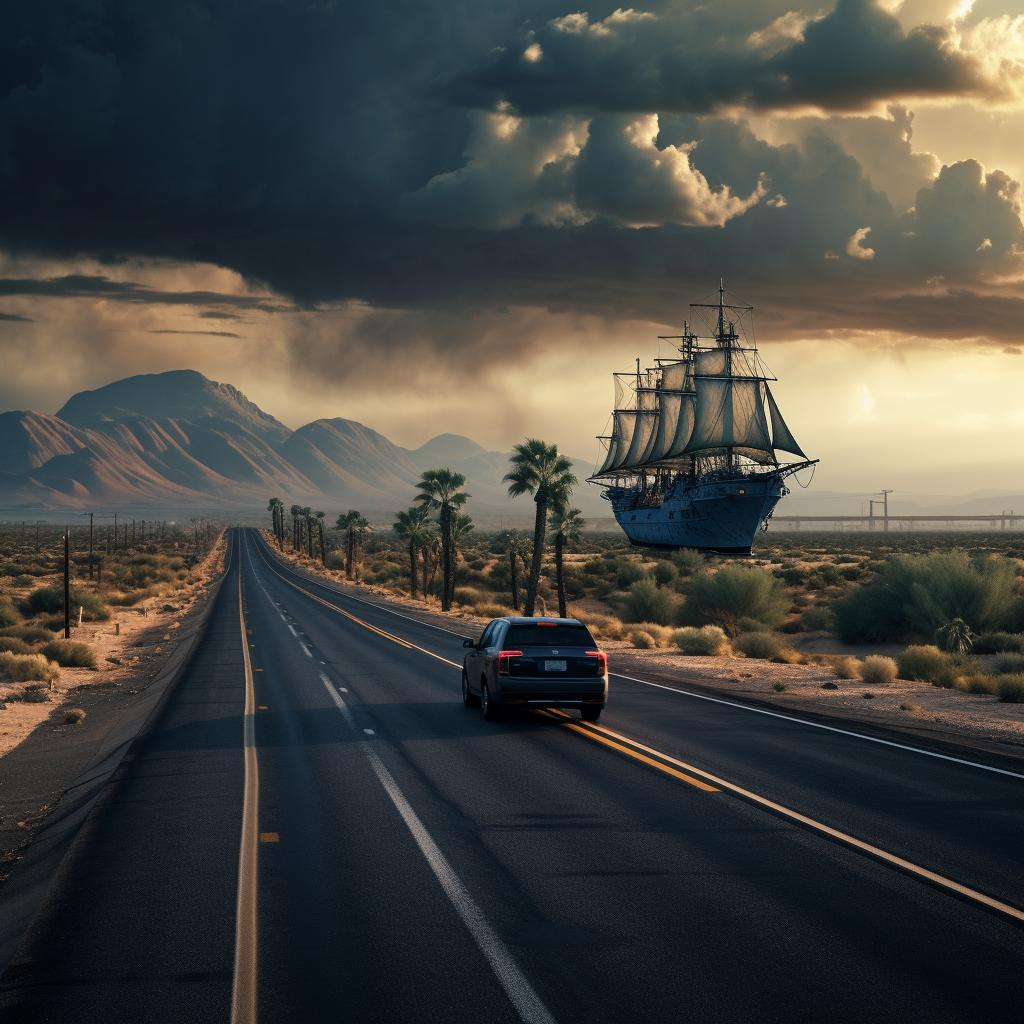

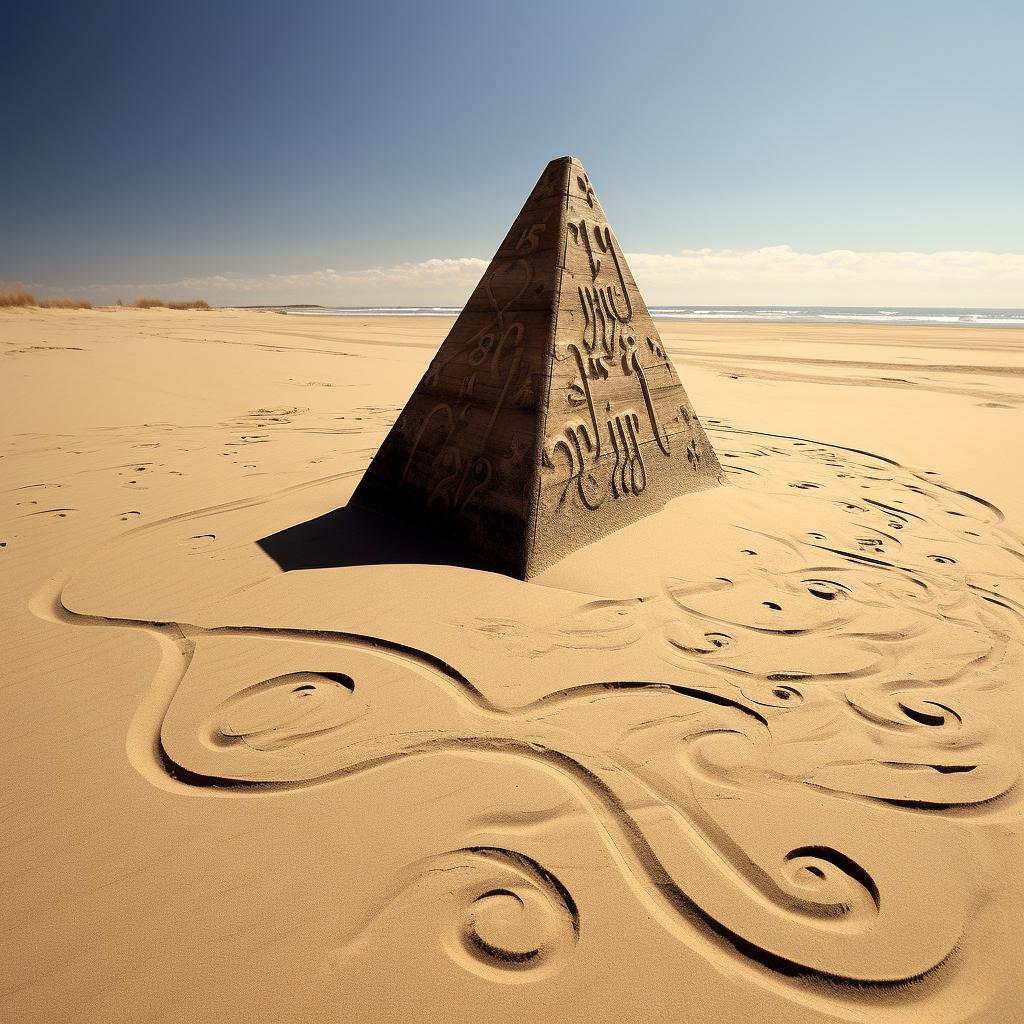

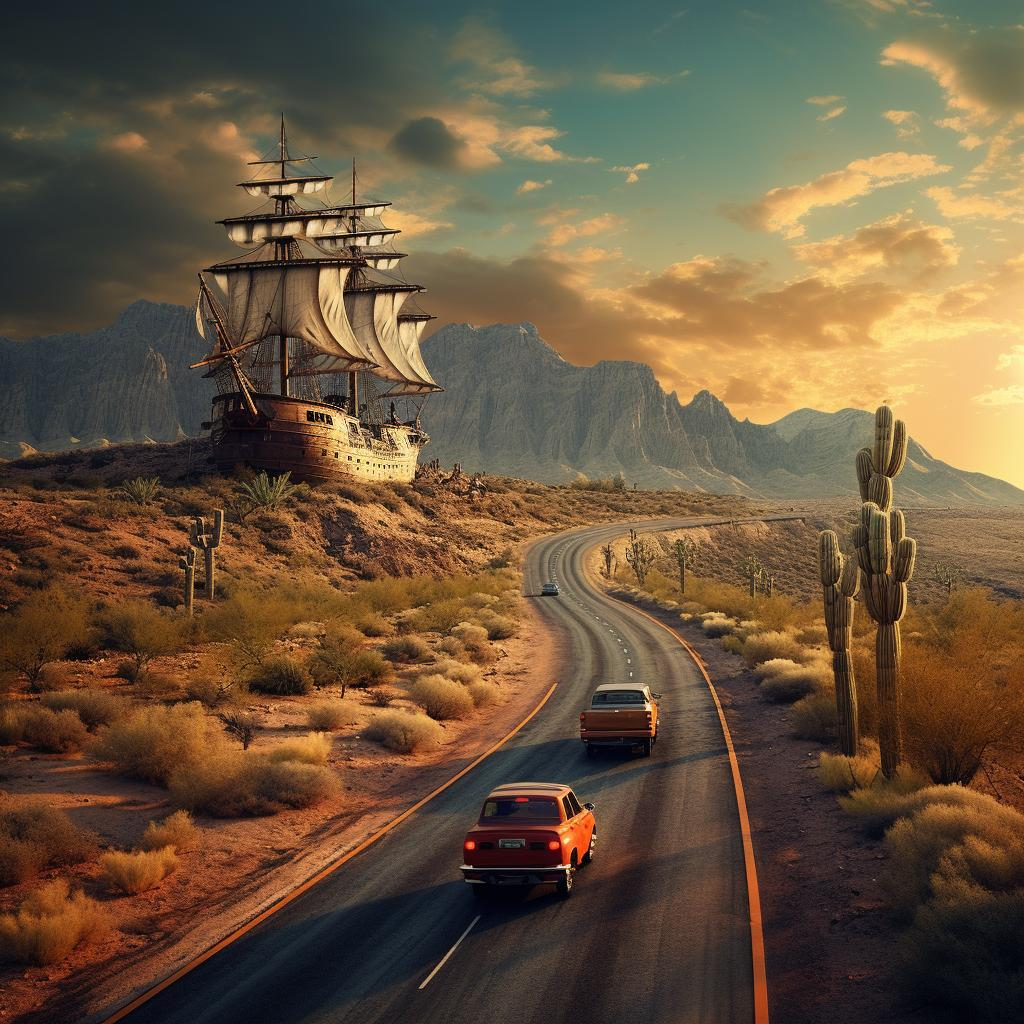

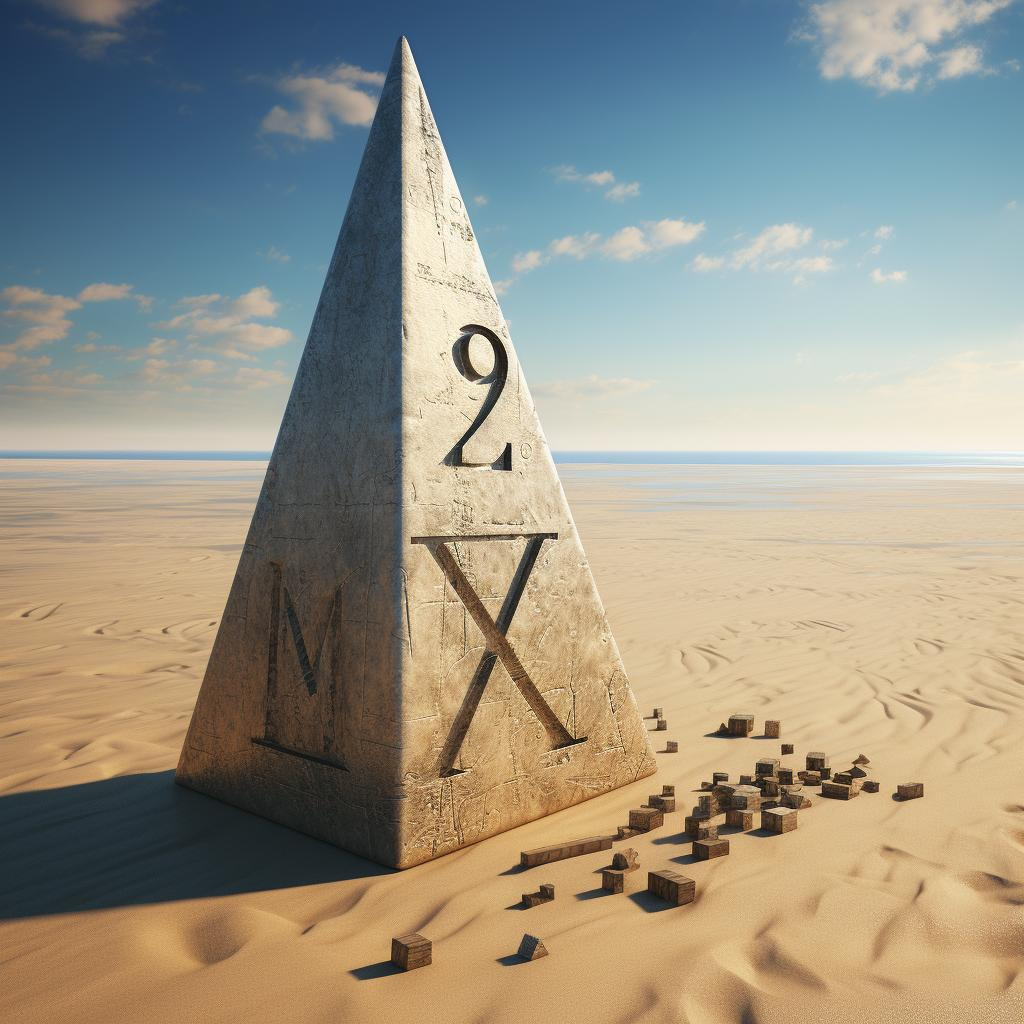

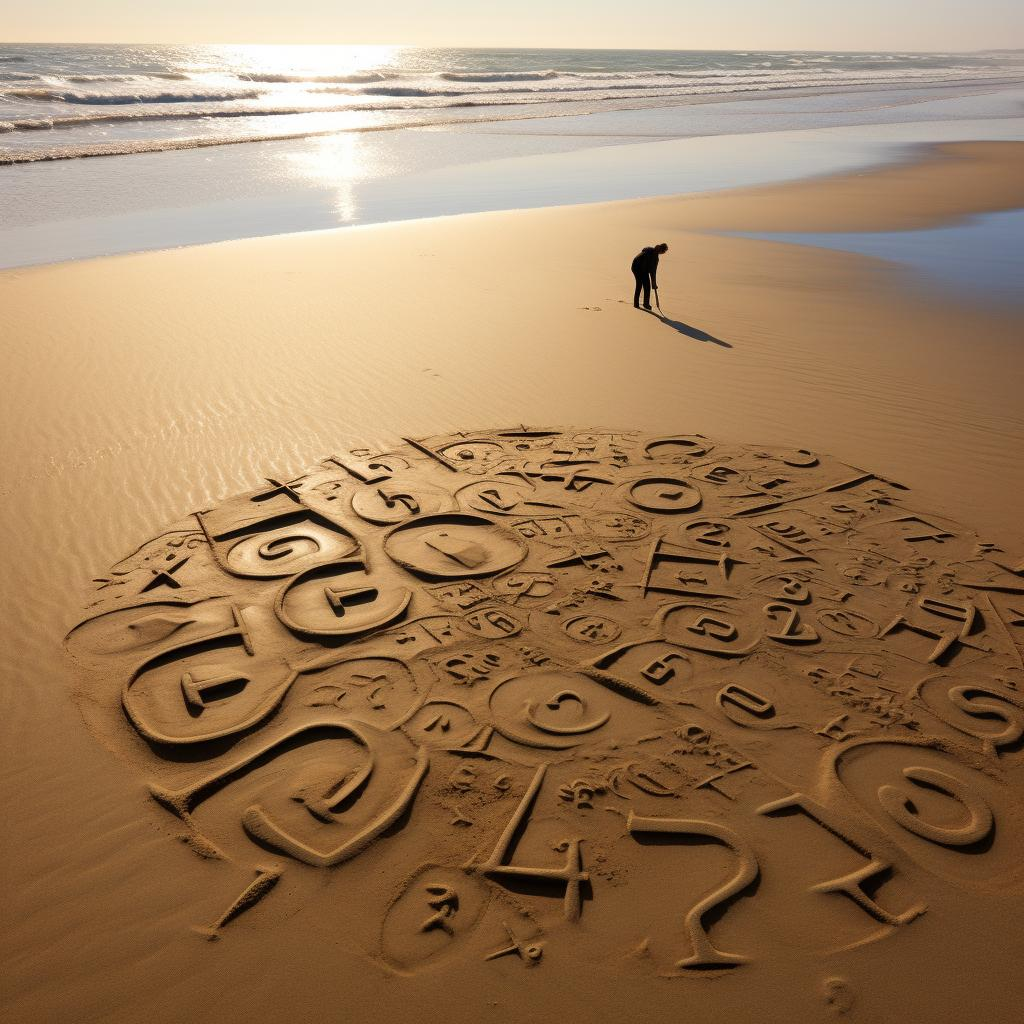

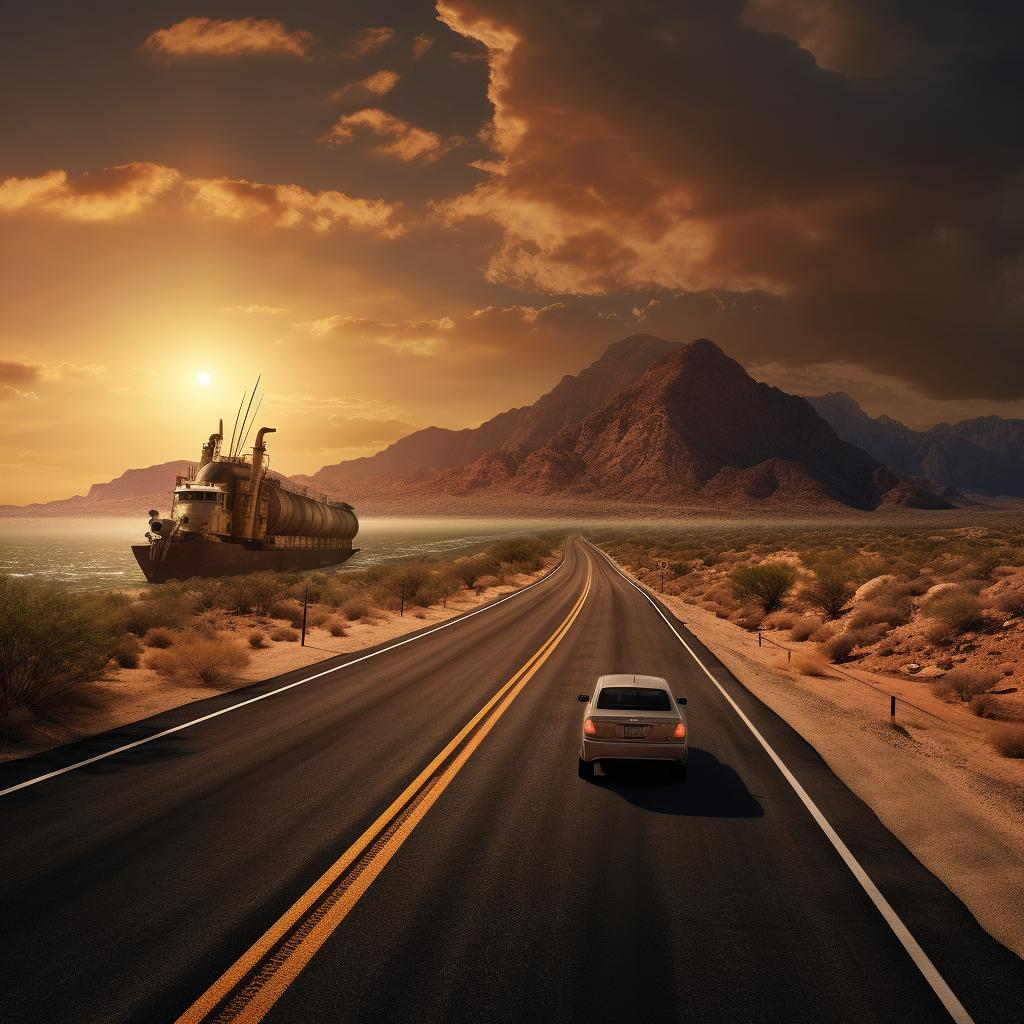

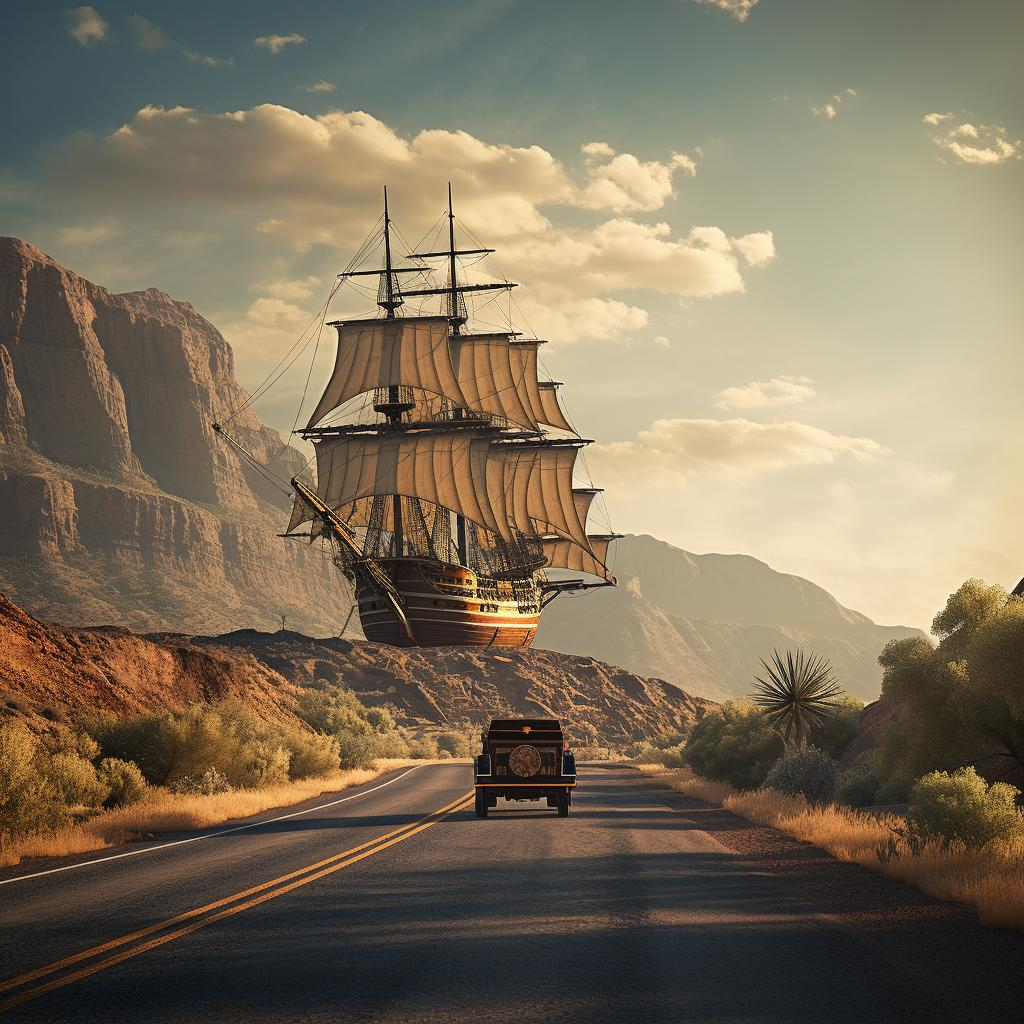

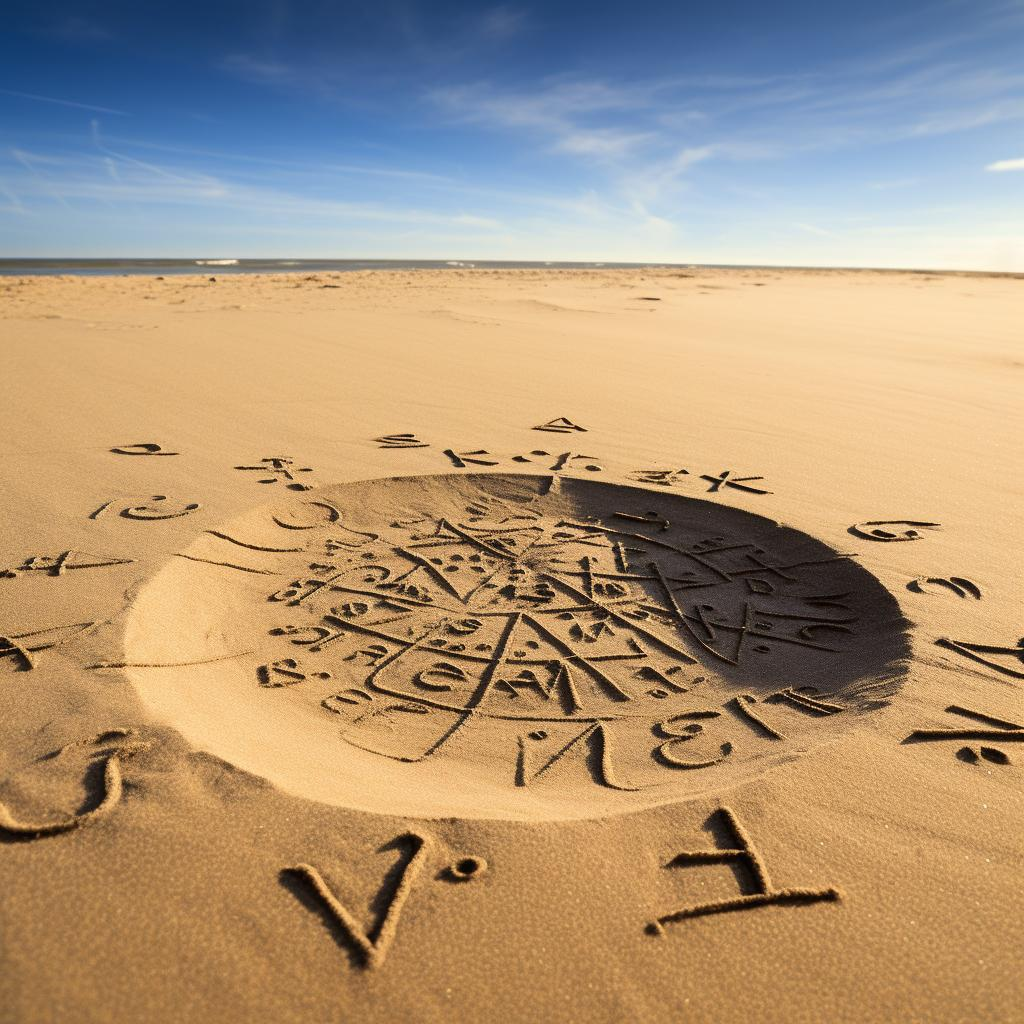

In [ ]:
from IPython.display import Image, display
import os

directory = '/content/output/'

for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        display(Image(filename=os.path.join(directory, filename)))

In [ ]:
import zipfile
from IPython.display import FileLink

# Zip the images
zip_name = '/content/images.zip'
with zipfile.ZipFile(zip_name, 'w') as zipf:
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            zipf.write(os.path.join(directory, filename), filename)  # Second arg is the arcname, to store the file name without any directory
